# Identifying Credit Card Fraud - Modeling

## Introduction

### 1. The Problem:



### 2. The data:



### 3. Features:



### 4. Scenario:

Our goal is to approach this as an actual business problem, to the best of our ability.  Unfortunately, given the nature of this project, there is no actual "client" or "customer" where we can discuss and properly assess the objectives of our solution.  As a result, I've consulted with my mentor and we have put forth the following scenario:

- We will set our objective to be to catch as many fraudulent transactions as possible, at the expense of incorrectly labeling some valid transactions as fraud. 
- As a result, our goal will be to optimize <b>recall</b>.


### 5. Plan:

In our previous notebook, we generated a baseline model that with poor performance due to the highly imbalanced nature of classes in this dataset.  In this notebook, we plan on dealing with the imbalance so that we can train more effective models.  We will try multiple combinations of sampling methods and algorithms to construct multiple models to compare.  

As for sampling methods, we will try random undersampling and random oversampling. A drawback of these two methods is that random undersampling of the majority class can potentially remove important data points, and random oversampling of the minority class can lead to overfitting.  As a result, we will also try to synthetically generate samples that are similar to the minority class distribution using SMOTE.  And finally, we will also try the "class_weight" parameter in each of the models to balance the weight of the majority and minority classes.

Speaking of models, we will try Logistic Regression, Random Forest, and XGBoost. In order to compare, our end goal will be to construct a table such as this:


| Algorithm | Class Balance | Train Precision | Train Recall | Train f1-score | Train Support | Test Precision | Test Recall | Test f1-score | Test Support |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| <b>Logistic Regression</b> | Undersample majority | ? | ? | ? | ? | ? | ? | ? | ? |
| | Oversample minority | ? | ? | ? | ? | ? | ? | ? | ? |
| | SMOTE | ? | ? | ? | ? | ? | ? | ? | ? |
| | class_weight balance | ? | ? | ? | ? | ? | ? | ? | ? |
| <b>Random Forest</b> | Undersample majority | ? | ? | ? | ? | ? | ? | ? | ? |
| | Oversample minority | ? | ? | ? | ? | ? | ? | ? | ? |
| | SMOTE | ? | ? | ? | ? | ? | ? | ? | ? |
| | class_weight balance | ? | ? | ? | ? | ? | ? | ? | ? |
| <b>XGboost</b> | Undersample majority | ? | ? | ? | ? | ? | ? | ? | ? |
| | Oversample minority | ? | ? | ? | ? | ? | ? | ? | ? |
| | SMOTE | ? | ? | ? | ? | ? | ? | ? | ? |
| | class_weight balance | ? | ? | ? | ? | ? | ? | ? | ? |



## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = pd.read_csv('../raw_data/X_train.csv', index_col=0)
X_test = pd.read_csv('../raw_data/X_test.csv', index_col=0)
y_train = pd.read_csv('../raw_data/y_train.csv', index_col=0)
y_test = pd.read_csv('../raw_data/y_test.csv', index_col=0)

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481794 entries, 572842 to 269493
Data columns (total 31 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   amt                 1481794 non-null  float64
 1   city_pop            1481794 non-null  int64  
 2   abnormal_hours      1481794 non-null  int64  
 3   time_diff           1481794 non-null  float64
 4   count_24_hour       1481794 non-null  float64
 5   count_7_days        1481794 non-null  float64
 6   count_30_days       1481794 non-null  float64
 7   gender_M            1481794 non-null  int64  
 8   dist_haversine      1481794 non-null  float64
 9   age                 1481794 non-null  int64  
 10  cat_entertainment   1481794 non-null  int64  
 11  cat_food_dining     1481794 non-null  int64  
 12  cat_gas_transport   1481794 non-null  int64  
 13  cat_grocery_net     1481794 non-null  int64  
 14  cat_grocery_pos     1481794 non-null  int64  
 15  cat_health_

In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370449 entries, 1634393 to 1228030
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   amt                 370449 non-null  float64
 1   city_pop            370449 non-null  int64  
 2   abnormal_hours      370449 non-null  int64  
 3   time_diff           370449 non-null  float64
 4   count_24_hour       370449 non-null  float64
 5   count_7_days        370449 non-null  float64
 6   count_30_days       370449 non-null  float64
 7   gender_M            370449 non-null  int64  
 8   dist_haversine      370449 non-null  float64
 9   age                 370449 non-null  int64  
 10  cat_entertainment   370449 non-null  int64  
 11  cat_food_dining     370449 non-null  int64  
 12  cat_gas_transport   370449 non-null  int64  
 13  cat_grocery_net     370449 non-null  int64  
 14  cat_grocery_pos     370449 non-null  int64  
 15  cat_health_fitness  370449 

In [31]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481794 entries, 572842 to 269493
Data columns (total 1 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   is_fraud  1481794 non-null  int64
dtypes: int64(1)
memory usage: 22.6 MB


In [32]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370449 entries, 1634393 to 1228030
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   is_fraud  370449 non-null  int64
dtypes: int64(1)
memory usage: 5.7 MB


In [33]:
y_train.value_counts()

is_fraud
0           1474073
1              7721
dtype: int64

In [34]:
y_test.value_counts()

is_fraud
0           368519
1             1930
dtype: int64

## Resampling

First, we'll create a dataframe with the counts of observations in X_train, y_train, as well as the counts of each class of the target variable "is_fraud".

In [7]:
counts_table = pd.DataFrame()

counts_table['technique'] = ['Original Data']
counts_table['X_train_shape'] = [X_train.shape[0]]
counts_table['y_train_shape'] = [y_train.shape[0]]
counts_table['is_fraud_0'] = [y_train.value_counts()[0]]
counts_table['is_fraud_1'] = [y_train.value_counts()[1]]

counts_table

,technique,X_train_shape,y_train_shape,is_fraud_0,is_fraud_1
0,Original Data,1481794,1481794,1474073,7721


#### Undersampling

We'll create new variables for X_train, y_train after they have been undersampled using RandomUnderSampler.

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)

X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

Next, we'll create a new row in our counts_table dataframe and append the counts.

In [9]:
new_row = {'technique':'Random Under Sampling', 
           'X_train_shape': X_train_rus.shape[0],
          'y_train_shape': y_train_rus.shape[0],
           'is_fraud_0': y_train_rus.value_counts()[0],
          'is_fraud_1': y_train_rus.value_counts()[1]}

counts_table = counts_table.append(new_row, ignore_index=True)
counts_table

,technique,X_train_shape,y_train_shape,is_fraud_0,is_fraud_1
0,Original Data,1481794,1481794,1474073,7721
1,Random Under Sampling,15442,15442,7721,7721


#### Oversampling

We'll create new variables for X_train, y_train after they have been oversampled using RandomOversampler.

In [10]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)

In [11]:
new_row = {'technique':'Random Over Sampling', 
           'X_train_shape': X_train_ros.shape[0],
          'y_train_shape': y_train_ros.shape[0],
           'is_fraud_0': y_train_ros.value_counts()[0],
          'is_fraud_1': y_train_ros.value_counts()[1]}

counts_table = counts_table.append(new_row, ignore_index=True)
counts_table

,technique,X_train_shape,y_train_shape,is_fraud_0,is_fraud_1
0,Original Data,1481794,1481794,1474073,7721
1,Random Under Sampling,15442,15442,7721,7721
2,Random Over Sampling,2948146,2948146,1474073,1474073


#### SMOTE

We'll create new variables for X_train, y_train after SMOTE

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority')

X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

In [13]:
new_row = {'technique':'SMOTE - minority', 
           'X_train_shape': X_train_sm.shape[0],
          'y_train_shape': y_train_sm.shape[0],
           'is_fraud_0': y_train_sm.value_counts()[0],
          'is_fraud_1': y_train_sm.value_counts()[1]}

counts_table = counts_table.append(new_row, ignore_index=True)
counts_table

,technique,X_train_shape,y_train_shape,is_fraud_0,is_fraud_1
0,Original Data,1481794,1481794,1474073,7721
1,Random Under Sampling,15442,15442,7721,7721
2,Random Over Sampling,2948146,2948146,1474073,1474073
3,SMOTE - minority,2948146,2948146,1474073,1474073


## Setting up table for model metric comparison

## Algorithm 1: Logistic Regression

### a) with Random Under Sampling
We'll begin by applying a baseline logistic regression to the random UNDER sampled data.

In [14]:
from sklearn.linear_model import LogisticRegression

lr_rus = LogisticRegression()
# Fit the model on the trainng data.
lr_rus.fit(X_train_rus, y_train_rus.values.ravel())

y_pred_train_1a = lr_rus.predict(X_train_rus)
y_pred_test_1a = lr_rus.predict(X_test)

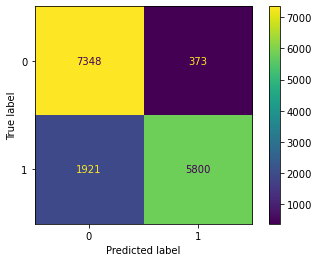

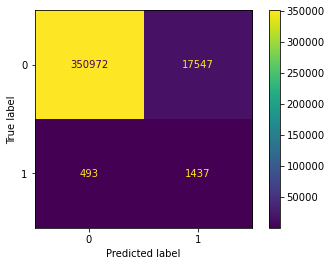

In [15]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr_rus, X_train_rus, y_train_rus)  
plot_confusion_matrix(lr_rus, X_test, y_test) 
plt.show()

In [16]:
from sklearn.metrics import classification_report

target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_rus, y_pred_train_1a, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test, y_pred_test_1a, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       0.79      0.95      0.86      7721
       fraud       0.94      0.75      0.83      7721

    accuracy                           0.85     15442
   macro avg       0.87      0.85      0.85     15442
weighted avg       0.87      0.85      0.85     15442

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.95      0.97    368519
       fraud       0.08      0.74      0.14      1930

    accuracy                           0.95    370449
   macro avg       0.54      0.85      0.56    370449
weighted avg       0.99      0.95      0.97    370449



### b) with Random Over Sampling

In [17]:
lr_ros = LogisticRegression()
# Fit the model on the trainng data.
lr_ros.fit(X_train_ros, y_train_ros.values.ravel())

y_pred_train_1b = lr_ros.predict(X_train_ros)
y_pred_test_1b = lr_ros.predict(X_test)

Training Confusion Matrix
Testing Confusion Matrix


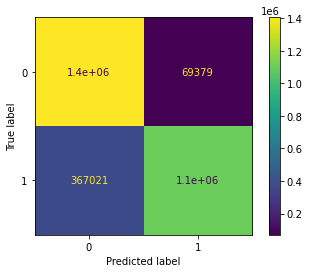

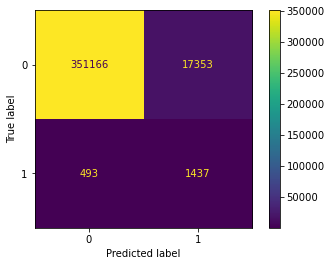

In [18]:
print('Training Confusion Matrix')
plot_confusion_matrix(lr_ros, X_train_ros, y_train_ros)  
print('Testing Confusion Matrix')
plot_confusion_matrix(lr_ros, X_test, y_test) 
plt.show()

In [19]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_ros, y_pred_train_1b, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test, y_pred_test_1b, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       0.79      0.95      0.87   1474073
       fraud       0.94      0.75      0.84   1474073

    accuracy                           0.85   2948146
   macro avg       0.87      0.85      0.85   2948146
weighted avg       0.87      0.85      0.85   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.95      0.98    368519
       fraud       0.08      0.74      0.14      1930

    accuracy                           0.95    370449
   macro avg       0.54      0.85      0.56    370449
weighted avg       0.99      0.95      0.97    370449



### c) with SMOTE

In [20]:
lr_sm = LogisticRegression()
# Fit the model on the trainng data.
lr_sm.fit(X_train_sm, y_train_sm.values.ravel())

y_pred_train_1c = lr_sm.predict(X_train_ros)
y_pred_test_1c = lr_sm.predict(X_test)

Training Confusion Matrix
Testing Confusion Matrix


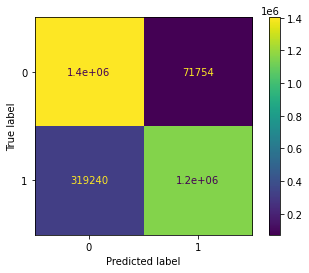

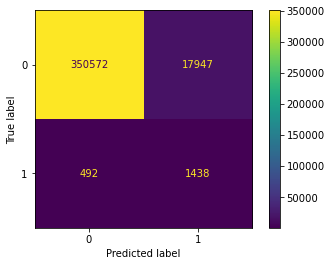

In [21]:
print('Training Confusion Matrix')
plot_confusion_matrix(lr_sm, X_train_sm, y_train_sm)  
print('Testing Confusion Matrix')
plot_confusion_matrix(lr_sm, X_test, y_test) 
plt.show()

In [22]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_sm, y_pred_train_1c, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test, y_pred_test_1c, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       0.79      0.95      0.87   1474073
       fraud       0.94      0.75      0.84   1474073

    accuracy                           0.85   2948146
   macro avg       0.87      0.85      0.85   2948146
weighted avg       0.87      0.85      0.85   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.95      0.97    368519
       fraud       0.07      0.75      0.13      1930

    accuracy                           0.95    370449
   macro avg       0.54      0.85      0.55    370449
weighted avg       0.99      0.95      0.97    370449



### d) with class_weight = balanced

In [26]:
lr_cw = LogisticRegression(class_weight='balanced')
# Fit the model on the trainng data.
lr_cw.fit(X_train, y_train.values.ravel())

y_pred_train_1d = lr_cw.predict(X_train)
y_pred_test_1d = lr_cw.predict(X_test)

Training Confusion Matrix
Testing Confusion Matrix


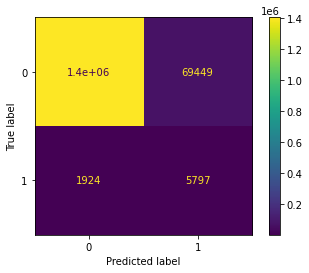

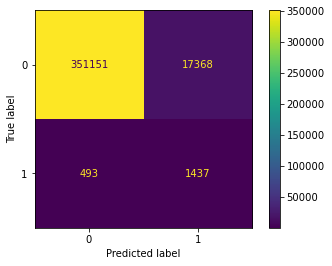

In [27]:
print('Training Confusion Matrix')
plot_confusion_matrix(lr_cw, X_train, y_train)  
print('Testing Confusion Matrix')
plot_confusion_matrix(lr_cw, X_test, y_test) 
plt.show()

In [28]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train, y_pred_train_1d, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test, y_pred_test_1d, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.95      0.98   1474073
       fraud       0.08      0.75      0.14      7721

    accuracy                           0.95   1481794
   macro avg       0.54      0.85      0.56   1481794
weighted avg       0.99      0.95      0.97   1481794

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.95      0.98    368519
       fraud       0.08      0.74      0.14      1930

    accuracy                           0.95    370449
   macro avg       0.54      0.85      0.56    370449
weighted avg       0.99      0.95      0.97    370449



## Algorithm 2: Random Forest

### a) with Random Under Sampling

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_rus = RandomForestClassifier()
rf_rus.fit(X_train_rus, y_train_rus.values.ravel())

y_pred_train_2a = rf_rus.predict(X_train_rus)
y_pred_test_2a = rf_rus.predict(X_test)

Training Confusion Matrix
Testing Confusion Matrix


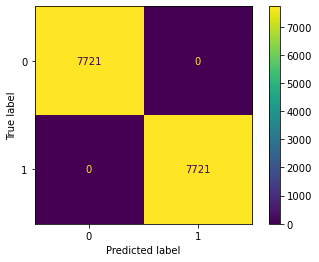

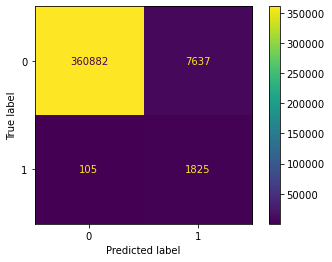

In [36]:
print('Training Confusion Matrix')
plot_confusion_matrix(rf_rus, X_train_rus, y_train_rus)  
print('Testing Confusion Matrix')
plot_confusion_matrix(rf_rus, X_test, y_test) 
plt.show()

In [37]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_rus, y_pred_train_2a, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test, y_pred_test_2a, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00      7721
       fraud       1.00      1.00      1.00      7721

    accuracy                           1.00     15442
   macro avg       1.00      1.00      1.00     15442
weighted avg       1.00      1.00      1.00     15442

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.98      0.99    368519
       fraud       0.19      0.95      0.32      1930

    accuracy                           0.98    370449
   macro avg       0.60      0.96      0.65    370449
weighted avg       1.00      0.98      0.99    370449



### b) with Random Over Sampling

In [38]:
rf_ros = RandomForestClassifier()
rf_ros.fit(X_train_ros, y_train_ros.values.ravel())

y_pred_train_2b = rf_ros.predict(X_train_ros)
y_pred_test_2b = rf_ros.predict(X_test)

In [40]:
from sklearn.metrics import confusion_matrix
cm_2b_train = confusion_matrix(y_train_ros.values.ravel(),y_pred_train_2b)
cm_2b_test = confusion_matrix(y_test.values.ravel(),y_pred_test_2b)

Text(0.5, 1.0, 'Training confusion matrix')

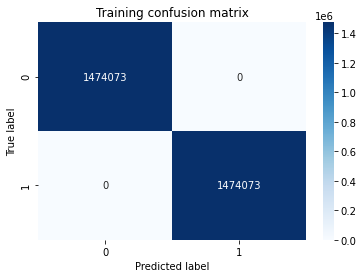

In [45]:
sns.heatmap(cm_2b_train, annot=True, fmt = '', cmap = 'Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Training confusion matrix')

Text(0.5, 1.0, 'Test confusion matrix')

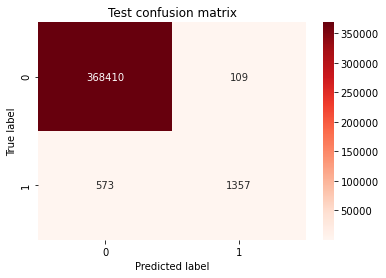

In [46]:
sns.heatmap(cm_2b_test, annot=True, fmt = '', cmap = 'Reds')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Test confusion matrix')

In [47]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_ros, y_pred_train_2b, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test, y_pred_test_2b, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.93      0.70      0.80      1930

    accuracy                           1.00    370449
   macro avg       0.96      0.85      0.90    370449
weighted avg       1.00      1.00      1.00    370449

